In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, precision_recall_curve

In [2]:
df = pd.read_csv("kamis_data.csv")

In [3]:
df.head()

,Commodity,Classification,Grade,Sex,Market,Wholesale,Retail,Supply Volume,County,Date,ProductID
0,Dry Maize,White Maize,-,-,Mwingi Town,46.67/Kg,55.00/Kg,40000.0,Kitui,2025-11-19,1
1,Dry Maize,White Maize,-,-,Kakamega Town,35.56/Kg,60.00/Kg,40000.0,Kakamega,2025-11-19,1
2,Dry Maize,White Maize,-,-,Kangeta,40.00/Kg,50.00/Kg,1300.0,Meru,2025-11-19,1
3,Dry Maize,Yellow Maize,-,-,Gikomba,77.78/Kg,100.00/Kg,NaN,Nairobi,2025-11-19,1
4,Dry Maize,White Maize,-,-,Gikomba,38.89/Kg,55.00/Kg,NaN,Nairobi,2025-11-19,1


In [4]:
df["Date"].describe

<bound method NDFrame.describe of 0          2025-11-19
1          2025-11-19
2          2025-11-19
3          2025-11-19
4          2025-11-19
              ...    
1284887    2025-11-19
1284888    2025-11-11
1284889    2025-08-13
1284890    2025-07-18
1284891    2025-05-21
Name: Date, Length: 1284892, dtype: object>

In [5]:
df['Date'] = pd.to_datetime(df['Date'])

In [6]:
df["Date"].describe

<bound method NDFrame.describe of 0         2025-11-19
1         2025-11-19
2         2025-11-19
3         2025-11-19
4         2025-11-19
             ...    
1284887   2025-11-19
1284888   2025-11-11
1284889   2025-08-13
1284890   2025-07-18
1284891   2025-05-21
Name: Date, Length: 1284892, dtype: datetime64[ns]>

In [7]:
df.isnull().sum()

Commodity              0
Classification         0
Grade                  0
Sex                    0
Market                 0
Wholesale              0
Retail                 0
Supply Volume     444437
County              2143
Date                   0
ProductID              0
dtype: int64

In [8]:
df = df.dropna(subset=['Date'])

In [9]:
cutoff = pd.Timestamp.today() - pd.DateOffset(years=3)
df = df[df['Date'] >= cutoff].reset_index(drop=True)

In [10]:
df.count()

Commodity         479670
Classification    479670
Grade             479670
Sex               479670
Market            479670
Wholesale         479670
Retail            479670
Supply Volume     360127
County            479581
Date              479670
ProductID         479670
dtype: int64

In [11]:
columns = df.columns.str.lower()
df.columns = columns

In [12]:
pd.set_option('display.max_rows', None)

for col in df.columns:
        print(f"\n--- Value Counts for '{col}' ---")
        try:
            print(df[col].value_counts(dropna=False))
        except Exception as e:
            print(f"Cannot compute value_counts for {col}: {e}")


--- Value Counts for 'commodity' ---
commodity
Cattle                               14595
Chicken                              13094
Goat                                 12621
Cabbages                             11521
Tomatoes                             11439
Dry Maize                            10936
Sheep                                10915
Dry Onions                           10800
Wheat Flour                          10572
Green Grams                           9926
Kales/Sukuma Wiki                     9645
Rice                                  8748
Carrots                               8658
Banana (Cooking)                      8540
White Irish Potatoes                  8406
Maize Flour                           8258
Beans (Yellow-Green)                  8012
Capsicums                             7813
Oranges                               7292
Spinach                               7285
Ground Nuts                           6973
Avocado                               6674
Water 

In [13]:
df = df.replace("-", pd.NA)
df.isna().mean().sort_values(ascending=False)

grade             0.916618
sex               0.886695
classification    0.691369
supply volume     0.249219
wholesale         0.174941
retail            0.167494
county            0.000186
commodity         0.000000
market            0.000000
date              0.000000
productid         0.000000
dtype: float64

While grade, sex, and classification have a lot of missing values, its not ideal to drop them. Domain knowledge is required to handle these missing values. Here's why:

* Commodities like coffee and tea do use grades and this is still valuable for those products.
* Sex is only relevant for livestock. Its not applicable to other commodities.
* Classification captures product variety or breed differences that directly affect typical market prices.

In [14]:
df['grade'] = df['grade'].fillna("Not graded")
df['sex'] = df['sex'].fillna("NA")
df['classification'] = df['classification'].fillna("Unknown")

In [15]:
df.isna().mean().sort_values(ascending=False)

supply volume     0.249219
wholesale         0.174941
retail            0.167494
county            0.000186
grade             0.000000
commodity         0.000000
classification    0.000000
sex               0.000000
market            0.000000
date              0.000000
productid         0.000000
dtype: float64

In [16]:
#checking missing values in the county variable
df[df['county'].isna()]

,commodity,classification,grade,sex,market,wholesale,retail,supply volume,county,date,productid
2682,Dry Maize,White Maize,Not graded,NA,test market,30.00/Kg,30.00/Kg,18000.0,NaN,2024-06-19,1
2683,Dry Maize,White Maize,Not graded,NA,test market,30.00/Kg,37.50/Kg,9000.0,NaN,2024-06-19,1
2684,Dry Maize,Mixed-Traditional,Not graded,NA,test market,30.00/Kg,30.00/Kg,18000.0,NaN,2024-06-19,1
2685,Dry Maize,White Maize,Not graded,NA,test market,30.00/Kg,30.00/Kg,1800.0,NaN,2024-06-19,1
2686,Dry Maize,Mixed-Traditional,Not graded,NA,test market,30.00/Kg,1.50/Kg,1800.0,NaN,2024-06-19,1
2687,Dry Maize,White Maize,Not graded,NA,test market,30.00/Kg,30.00/Kg,18000.0,NaN,2024-06-19,1
29682,Green Grams,Local-Special,Not graded,NA,test market,180.00/Kg,200.00/Kg,600.0,NaN,2024-06-20,10
29683,Green Grams,Local-Special,Not graded,NA,test market,180.00/Kg,200.00/Kg,600.0,NaN,2024-06-20,10
29684,Green Grams,Local-Special,Not graded,NA,test market,180.00/Kg,200.00/Kg,600.0,NaN,2024-06-20,10
29685,Green Grams,Local-Special,Not graded,NA,test market,180.00/Kg,200.00/Kg,600.0,NaN,2024-06-20,10


For counties with missing values, they were all "test markets". I will drop these because they are not actual markets.

In [17]:
df = df.dropna(subset=['county'])
df = df.dropna(subset=['wholesale'])
df = df.dropna(subset=['retail'])

df[df['supply volume'].isna()]

In [18]:
df = df.drop(columns=['supply volume', 'productid'])

In [19]:
df.isnull().sum()

commodity         0
classification    0
grade             0
sex               0
market            0
wholesale         0
retail            0
county            0
date              0
dtype: int64

In [20]:
df['wholesale'] = df['wholesale'].str.split('/').str[0].astype(float)
df['retail'] = df['retail'].str.split('/').str[0].astype(float)

In [21]:
#df['retail'] = df['retail'].astype(float)
#df['wholesale'] = df['wholesale'].astype(float)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 315861 entries, 0 to 479664
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   commodity       315861 non-null  object        
 1   classification  315861 non-null  object        
 2   grade           315861 non-null  object        
 3   sex             315861 non-null  object        
 4   market          315861 non-null  object        
 5   wholesale       315861 non-null  float64       
 6   retail          315861 non-null  float64       
 7   county          315861 non-null  object        
 8   date            315861 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(6)
memory usage: 24.1+ MB


In [23]:
df.head()

,commodity,classification,grade,sex,market,wholesale,retail,county,date
0,Dry Maize,White Maize,Not graded,NA,Mwingi Town,46.67,55.0,Kitui,2025-11-19
1,Dry Maize,White Maize,Not graded,NA,Kakamega Town,35.56,60.0,Kakamega,2025-11-19
2,Dry Maize,White Maize,Not graded,NA,Kangeta,40.00,50.0,Meru,2025-11-19
3,Dry Maize,Yellow Maize,Not graded,NA,Gikomba,77.78,100.0,Nairobi,2025-11-19
4,Dry Maize,White Maize,Not graded,NA,Gikomba,38.89,55.0,Nairobi,2025-11-19


In [29]:
((df['wholesale'] > df['retail']).mean() * 100).round(2)

np.float64(0.0)

Some 2.55% of the dataset have wholesale prices as larger than retail prices. This might be due to:
* unit mismatch
* manual entry mistakes
* outdated wholesale vs fresh retail prices

The best decision is to drop these because imputing >8k records is not the best use of resources.

In [28]:
df = df[df['wholesale'] <= df['retail']]

In [36]:
# 1. data-driven percentiles
qs = df["retail"]/df["wholesale"]
print("Markup percentiles:\n", (qs.quantile(np.arange(0.5,1,0.05))*100).round(1))

# 2. ROC-style search on wholesale vs retail
fpr, tpr, roc_thresh = roc_curve(
    (df["retail"]>df["wholesale"]).astype(int),
    df["retail"]/df["wholesale"]
)
# pick Youden
best_roc = roc_thresh[np.argmax(tpr - fpr)]
print(f"\nYouden J-optimal markup: {best_roc*100:.1f}%")

# 3. Precision-Recall search for rare extreme
prec, rec, pr_thresh = precision_recall_curve(
    (df["retail"]>df["wholesale"]).astype(int),
    df["retail"]/df["wholesale"]
)
# pick 90% precision
idx = np.where(prec>=0.9)[0]
if len(idx):
    best_pr = pr_thresh[idx[0]]
    print(f"90%-precision markup: {best_pr*100:.1f}%")

Markup percentiles:
 0.50    128.6
0.55    133.3
0.60    133.3
0.65    140.0
0.70    142.9
0.75    150.0
0.80    153.6
0.85    166.7
0.90    178.6
0.95    202.5
dtype: float64

Youden J-optimal markup: 100.0%
90%-precision markup: 100.0%


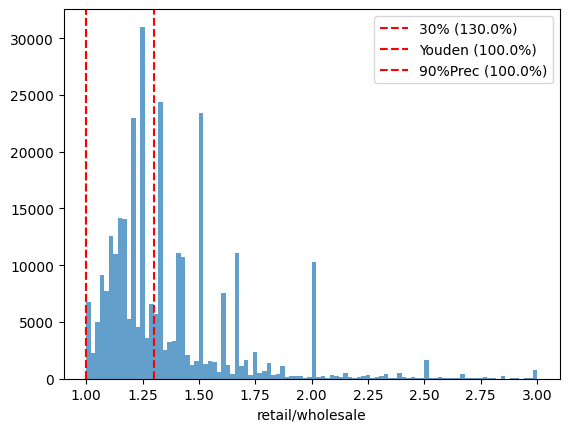

In [40]:
# quick viz
plt.hist(qs, bins=100, range=(1,3), alpha=.7)
for v,c in zip([1.3, best_roc, best_pr], ["30%","Youden","90%Prec"]):
    plt.axvline(v, color="red", ls="--", label=f"{c} ({v*100:.1f}%)")
plt.legend(); 
plt.xlabel("retail/wholesale"); 
#plt.show()
plt.savefig('thresholds.pdf')

<Figure size 640x480 with 0 Axes>